# Setup and Initialization

In [1]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

In [2]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')

## Dataset Analysis

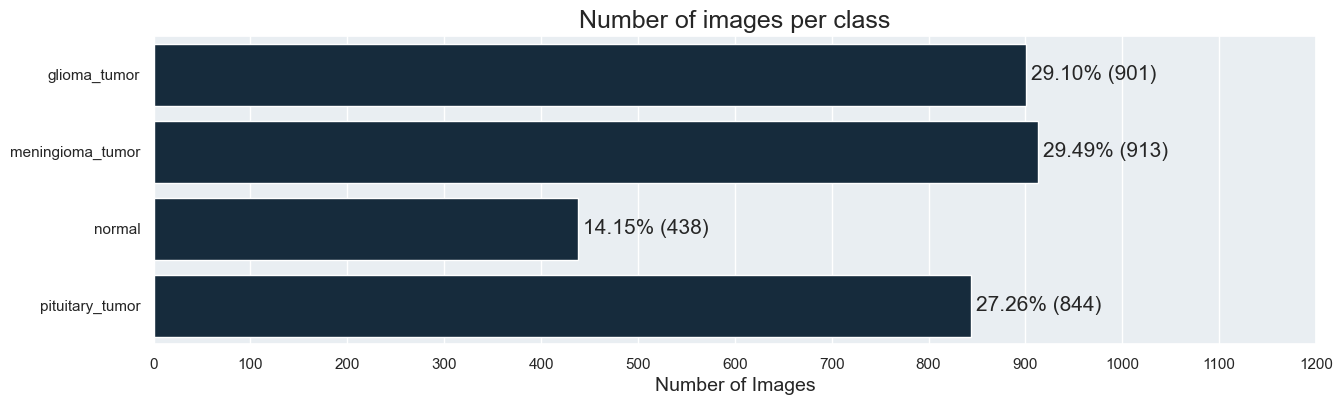

In [4]:
# Directory where the image folders are located
base_dir = 'Dataset1'

# Obtain class names from the folder names in base_dir
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]

# Counting the number of images in each folder
counts = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))

# Calculating the total number of images
total_count = sum(counts)

# Calculating the percentages
percentages = [(count / total_count) * 100 for count in counts]

# Set the figure size
plt.figure(figsize=(15, 4))

# Create a horizontal bar plot
ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42')

# Set x-axis interval (adjust as needed)
ax.set_xticks(range(0, max(counts) + 1, 1000))

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)

# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)

# Set x-axis interval
ax.set_xticks(range(0, max(counts) + 300, 100))

# Set the title and show the plot
plt.title("Number of images per class", fontsize=18)
plt.show()

In [5]:
# Lists to store heights and widths of all images
heights = []
widths = []

# Initialize sets to store unique dimensions
unique_dims = set()

# Loop over each class and their respective images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Add the dimensions (height, width, channels) to the set
            unique_dims.add((img.shape[0], img.shape[1]))
            
            # Append heights and widths for statistical calculations
            heights.append(img.shape[0])
            widths.append(img.shape[1])

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

All images have the same dimensions: (256, 256)


# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(15, 3)) 
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        # Convert the BGR image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Setting the random seed for reproducibility
np.random.seed(42)

# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images")

# Dataset Prepration

## Centralizing Dataset Information

In [7]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop over each class and append the image file paths with their respective labels to the data list
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath         label
0    Dataset1\glioma_tumor\G_1.jpg  glioma_tumor
1   Dataset1\glioma_tumor\G_10.jpg  glioma_tumor
2  Dataset1\glioma_tumor\G_100.jpg  glioma_tumor
3  Dataset1\glioma_tumor\G_101.jpg  glioma_tumor
4  Dataset1\glioma_tumor\G_102.jpg  glioma_tumor

In [8]:
print("Total number of images:", df.shape[0])

Total number of images: 3096


In [9]:
# Deleting unnecessary variables to free up memory
del data, all_images

## Data Splitting into Training & Validation Sets

In [10]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (2476, 2)
Validation data shape: (620, 2)


In [11]:
# Display the first few rows of the train DataFrame
train_df.head(10)

filepath             label
1527  Dataset1\meningioma_tumor\M_663.jpg  meningioma_tumor
1212   Dataset1\meningioma_tumor\M_38.jpg  meningioma_tumor
828       Dataset1\glioma_tumor\G_845.jpg      glioma_tumor
1528  Dataset1\meningioma_tumor\M_664.jpg  meningioma_tumor
3034   Dataset1\pituitary_tumor\P_803.jpg   pituitary_tumor
545       Dataset1\glioma_tumor\G_590.jpg      glioma_tumor
696       Dataset1\glioma_tumor\G_726.jpg      glioma_tumor
481       Dataset1\glioma_tumor\G_532.jpg      glioma_tumor
1033  Dataset1\meningioma_tumor\M_218.jpg  meningioma_tumor
2198             Dataset1\normal\N_50.jpg            normal

In [12]:
# Display the first few rows of the validation DataFrame
val_df.head(10)

filepath             label
2788   Dataset1\pituitary_tumor\P_582.jpg   pituitary_tumor
1496  Dataset1\meningioma_tumor\M_635.jpg  meningioma_tumor
940   Dataset1\meningioma_tumor\M_134.jpg  meningioma_tumor
3093    Dataset1\pituitary_tumor\P_97.jpg   pituitary_tumor
273       Dataset1\glioma_tumor\G_345.jpg      glioma_tumor
85        Dataset1\glioma_tumor\G_176.jpg      glioma_tumor
1011  Dataset1\meningioma_tumor\M_199.jpg  meningioma_tumor
1182  Dataset1\meningioma_tumor\M_352.jpg  meningioma_tumor
2803   Dataset1\pituitary_tumor\P_596.jpg   pituitary_tumor
1043  Dataset1\meningioma_tumor\M_227.jpg  meningioma_tumor

## Augmentation of Dataset with Artificially Degraded Images 

In [13]:
def add_gaussian_noise(image, mean=0, std=0.05):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [14]:
def apply_blur(image, kernel_size=5):
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [15]:
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [16]:
def count_images(dataframe):
    """ Function to count the total number of images in a DataFrame """
    return dataframe.shape[0]

In [17]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 2476
Total number of validation images: 620


In [18]:
def augment_images(dataframe, base_dir):
    modified_data = []
    
    for _, row in dataframe.iterrows():
        img_path = row['filepath']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [19]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df, base_dir)
val_df = augment_images(val_df, base_dir)

In [20]:
# Count and print the number of images in the training and validation sets after the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 4952
Total number of validation images: 1240


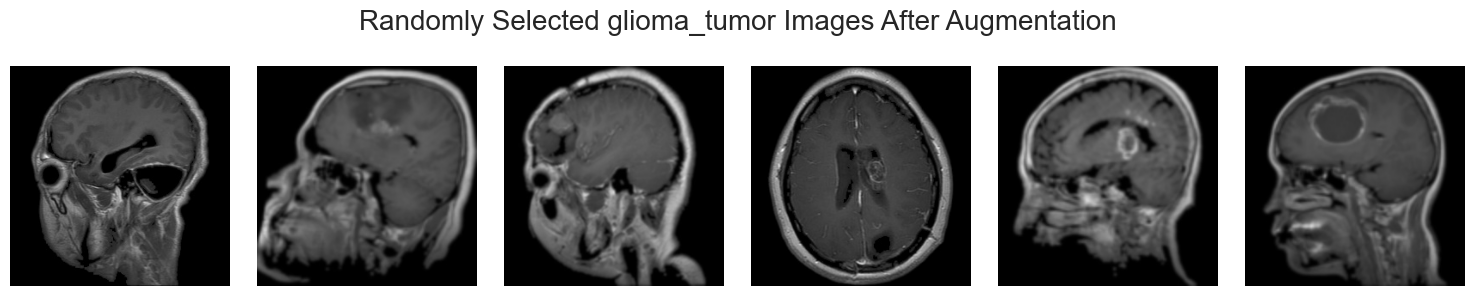

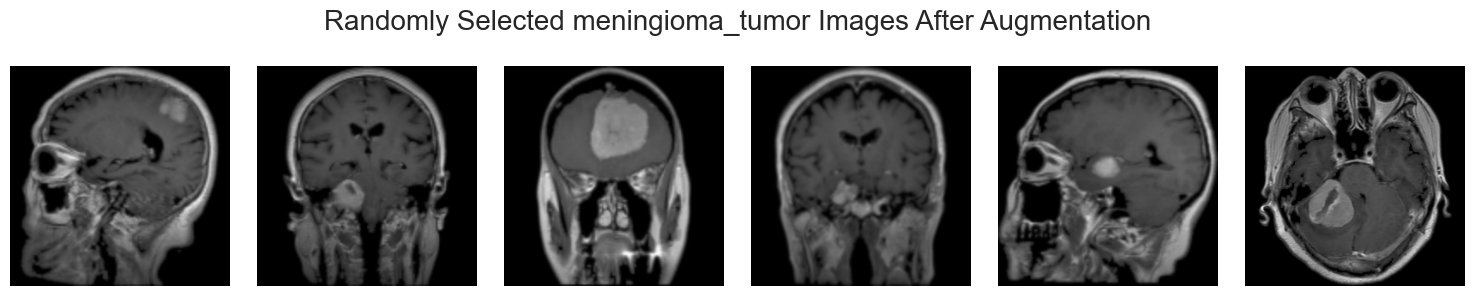

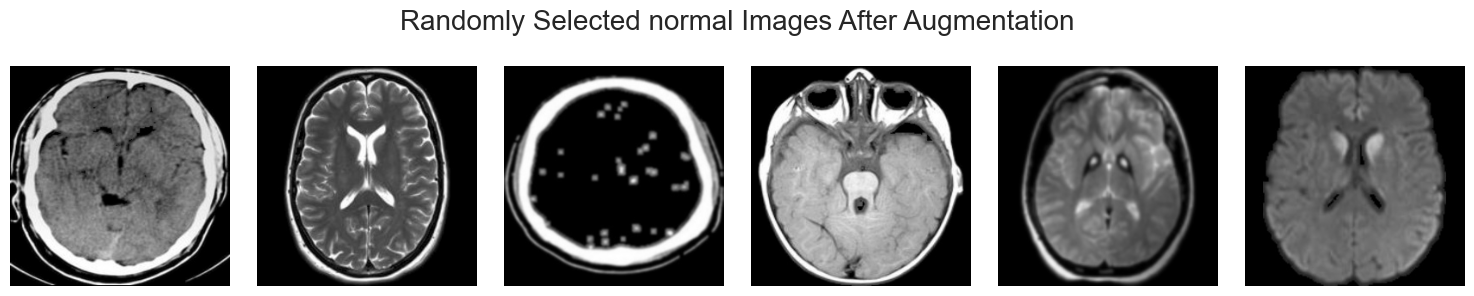

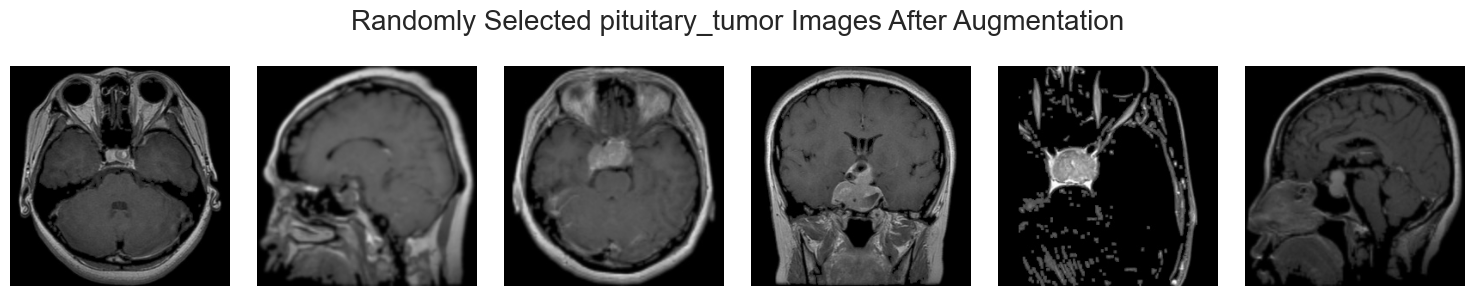

In [21]:
# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

## Establishing Data Generators for Model Input

In [22]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):
    """
    Creates and returns training and validation data generators with optional preprocessing.
    
    Parameters:
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - preprocessing_function (function, optional): Preprocessing function specific to a model. Defaults to None.
    - batch_size (int, optional): Number of images per batch for the generators. Defaults to 32.
    - image_dimensions (tuple, optional): Dimensions to which the images will be resized (height, width). Defaults to (224, 224).
    
    Returns:
    - train_generator (ImageDataGenerator): Generator for training data.
    - val_generator (ImageDataGenerator): Generator for validation data.
    
    Notes:
    - The validation generator does not use any augmentations.
    - If provided, the preprocessing function is applied to both generators.
    """

    # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
        preprocessing_function=preprocessing_function
    )

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col="filepath",                   # Column with paths to image files
        y_col="label",                      # Column with image labels
        target_size=image_dimensions,       # Resize all images to size of 224x224 
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,                            # Seed for random number generator to ensure reproducibility
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",                       
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,
        shuffle=False                       # Shuffling not necessary for validation data
    )
    
    # Return the training and validation generators
    return train_generator, val_generator

In [23]:
# Create the data generators
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)

# Fetch a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 4952 validated image filenames belonging to 4 classes.
Found 1240 validated image filenames belonging to 4 classes.
Shape of the first image in the batch: (224, 224, 3)


In [24]:
# Retrieve the class names
class_indices = train_generator.class_indices

# Sorting the class indices to get the list of class names in the correct order
class_names = sorted(class_indices, key=class_indices.get)
class_names 

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Model Architecture Development

In [25]:
# Load the pre-trained ResNet50V2 model without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [26]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [28]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

# Full Model Training and Fine-Tuning

In [29]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=32, num_epochs=50):
    """
    Creates and returns training and validation data generators with optional preprocessing and augmentation.
    
    Parameters:
    - model: Model, a compiled instance of a Keras model to be trained.
    - train_df: DataFrame, the training data.
    - val_df: DataFrame, the validation data.
    - preprocessing_function: function, preprocessing function to be applied to input data.
    - image_dimensions: tuple, dimensions of the images (width, height).
    - batch_size: int, number of samples per batch of computation.
    - num_epochs: int, number of epochs to train the model.
    
    Returns:
    - model: The trained model instance.
    - history: A History object containing the training history.
    - val_generator: The validation data generator.
    """

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[reduce_lr, early_stopping]
    )
    
    return model, history, val_generator

In [30]:
# Fine-tune the model
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=20)

Found 4952 validated image filenames belonging to 4 classes.
Found 1240 validated image filenames belonging to 4 classes.
Epoch 1/20


155/155 [==============================] - 340s 2s/step - loss: 0.4995 - accuracy: 0.8100 - val_loss: 0.3434 - val_accuracy: 0.8734 - lr: 1.0000e-04
Epoch 2/20
155/155 [==============================] - 323s 2s/step - loss: 0.1606 - accuracy: 0.9459 - val_loss: 0.2714 - val_accuracy: 0.9089 - lr: 1.0000e-04
Epoch 3/20
155/155 [==============================] - 321s 2s/step - loss: 0.1254 - accuracy: 0.9568 - val_loss: 0.2078 - val_accuracy: 0.9419 - lr: 1.0000e-04
Epoch 4/20
155/155 [==============================] - 321s 2s/step - loss: 0.0943 - accuracy: 0.9689 - val_loss: 0.1216 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 5/20
155/155 [==============================] - 322s 2s/step - loss: 0.0599 - accuracy: 0.9798 - val_loss: 0.1385 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 6/20
155/155 [==============================] - 326s 2s/step - loss: 0

# Model Performance Assessment

## Visualizing the Learning Curves

In [32]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

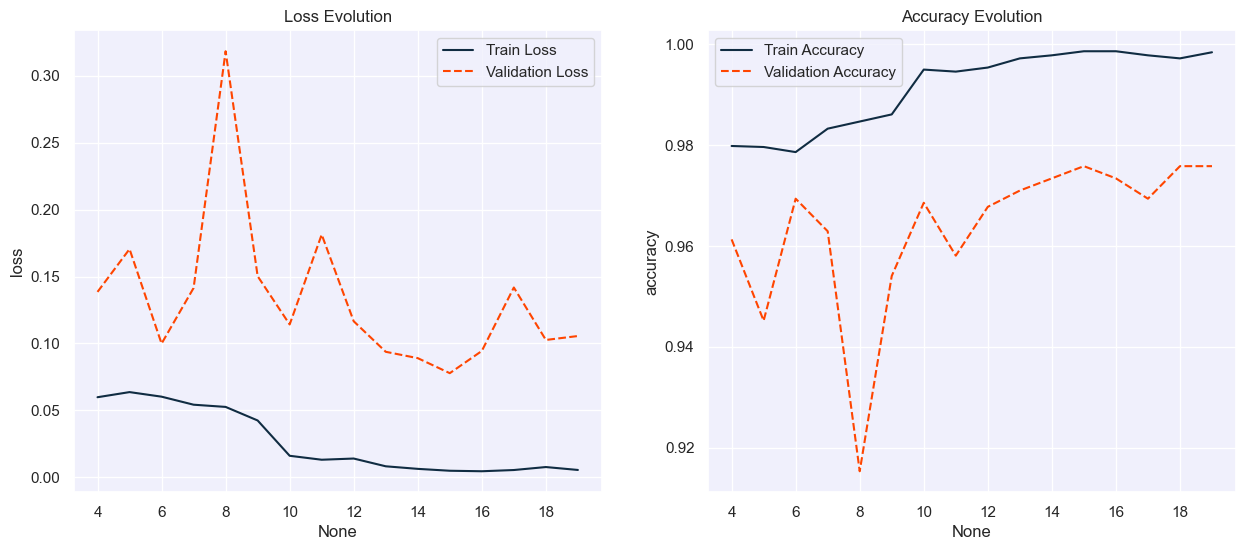

In [33]:
plot_learning_curves(history)

## Performance Metrics Assessment

In [34]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

39/39 [==============================] - 26s 639ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.96      0.97       360
meningioma_tumor       0.96      0.97      0.97       366
          normal       0.99      0.99      0.99       176
 pituitary_tumor       0.97      1.00      0.98       338

        accuracy                           0.98      1240
       macro avg       0.98      0.98      0.98      1240
    weighted avg       0.98      0.98      0.98      1240





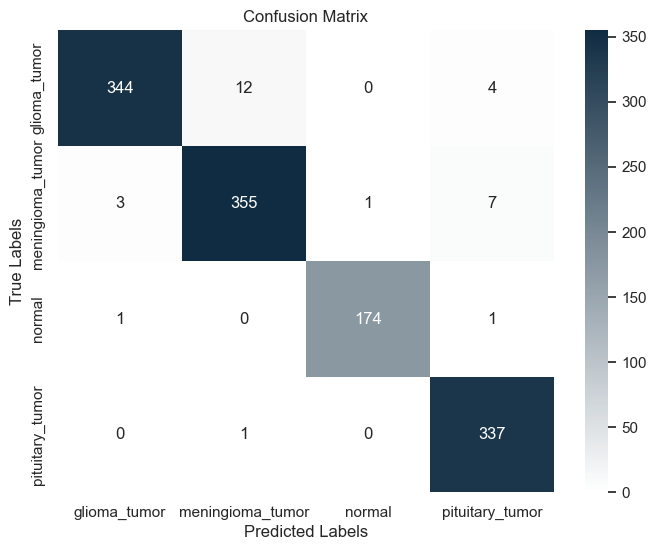

In [35]:
evaluate_model_performance(model, val_generator, classes)

## Saving the Model for Deployment

In [36]:
# Save the entire ResNet50V2 model
model.save('ResNet50V2BTD_model.h5')